In [1]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [13]:
# set path to .xyz file location
data_path = "C:/Users/ppant/Documents/TU Delft/2024 Q3/GEO5017/GEO5017_Group_13/pointclouds-500/"   
# eg: C:/Users/Dell/Desktop/pointclouds

# data_path = "E:/Building Technology/Semester 2/Quarter 3/GEO5017_Machine Learning for the Built Environment/Assignment/GEO5017_A2_Group 17/GEO5017_A2_Group 17/GEO5017-A2-Classification/data/pointclouds"

# get a list of all .xyz files in the folder
file_paths = []
for filename in os.listdir(data_path):
    
    file_path = data_path + filename
    file_paths.append(file_path)

# looping over files list to extract xyz values
point_cloud = []
for file in file_paths:
    df = pd.read_csv(file, delimiter=" ", names=['x', 'y', 'z'])
    x_values = df['x'].values
    y_values = df['y'].values
    z_values = df['z'].values
    point_cloud.append(np.column_stack((x_values, y_values, z_values)))
# print(point_cloud)
# len(point_cloud)

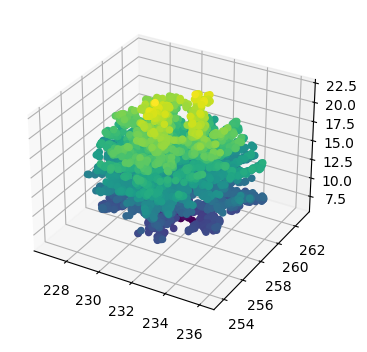

In [22]:
# visualise elements individually in 3D space (optional)
t = int(input("Object visualization query: "))  # the item no. for 3D viz
x_data = point_cloud[t][:, 0]
y_data = point_cloud[t][:, 1]
z_data = point_cloud[t][:, 2]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, alpha=1)
plt.show()


In [18]:
# function to get projected areas of the item w.r.t bounding box
def get_areas(X, Y):
    X_rounded = [round(x, 0) for x in X]
    Y_rounded = [round(y, 0) for y in Y]
    x_max, x_min, y_max, y_min = max(X_rounded), min(X_rounded), max(Y_rounded), min(Y_rounded)
    x_max, x_min = x_max + 0.5, x_min - 0.5
    y_max, y_min = y_max + 0.5, y_min - 0.5
    bb_len, bb_width = abs(x_max - x_min), abs(y_max - y_min)
    bb_area = bb_len * bb_width
    string_repr = [','.join([str(x), str(y)]) for x, y in zip(X_rounded, Y_rounded)]
    projected_area = len(set(string_repr))

    return projected_area/bb_area * 100

In [82]:

# empty lists to store the features for performing classification (feature set)
max_heights = []
ground_area = []
density = []
# projected = []
projected_bb = []
average_height = []
planarity = []

# defining each feature
for item in point_cloud:

    # contains all the x, y and z values of each object
    x = []
    y = []
    z = []
    value = 0
    # contains no of points in each object
    points = []

    for value in item:
        # Extract the x, y, z values from the object
        x_cord = value[0]
        x.append(x_cord)
        y_cord = value[1]
        y.append(y_cord)
        z_cord = value[2]
        z.append(z_cord)
        points.append(value)
        value += 1

    # feature 1: calculate the max height of the object
    max_height = np.max(z)
    max_heights.append(max_height)

    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    min_z, max_z = np.min(z), np.max(z)

    # feature 2: calculate the ground area covered by the object through a bounding box
    area = (max_x - min_x) * (max_y - min_y)
    ground_area.append(area)

    # feature 3: calculate the density
    nr_points = len(points)
    volume = ((max_x - min_x) * (max_y - min_y) * (max_z - min_z))
    density_temp = volume/nr_points
    density.append(density_temp)

    # feature 4: ratio of projected area of object with the bounding box
    ratio_bb = get_areas(x, y)  # , proj_area
    # projected.append(proj_area)
    projected_bb.append(ratio_bb)

    # feature 5:
    z_height = np.mean(z)
    average_height.append(z_height)

    # feature 6: calculate the planarity of the object
    # Eigenvalues: when multiplied to a given vector, result in a scaled version of that vector
    # ratio of the smallest eigenvalue to the sum of all three eigenvalues
    # Planarity varies between 0 and 1,
    # where 0 indicates that all the eigenvalues are equal,
    # meaning that the surface is entirely planar,
    # and 1 indicates that one eigenvalue is significantly smaller than the other two,
    # indicating a significant variation in the surface.
    # https://nl.mathworks.com/help/matlab/ref/eig.html
    covariance_matrix = np.cov(np.array([x, y, z]))
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues.sort()
    planarity_temp = ((eigenvalues[1] + eigenvalues[0]) / (eigenvalues[0] + eigenvalues[1] + eigenvalues[2]))
    # planarity_temp = (eigenvalues[0] / (eigenvalues[0] + eigenvalues[1] + eigenvalues[2]))
    planarity.append(planarity_temp)

# creating a feature vector
feature_names = ['max_heights', 'ground_area', 'density', 'projected_bb', 'average_height', 'planarity']  # 'projected'
features = pd.DataFrame({
    'max_heights': max_heights,
    'ground_area': ground_area,
    'density': density,
    # 'projected area': projected,
    'projected_bb': projected_bb,
    'average_height': average_height,
    'planarity': planarity
})
print(features)

     max_heights  ground_area   density  projected_bb  average_height  \
0      21.730000    48.731934  0.135232     91.666667       20.003383   
1      10.470000    64.715485  0.112223     78.571429        9.385178   
2      17.570000   273.662312  0.228969     83.006536       14.986387   
3      18.469999   354.430061  0.243781     72.474747       15.856272   
4      11.750000   520.882345  0.223818     61.739130        9.823214   
..           ...          ...       ...           ...             ...   
495    13.540000    40.565323  0.106486     75.000000        9.438339   
496    17.170000   106.506569  0.198018     71.969697       11.659321   
497    13.110000    36.537662  0.213788     77.083333        9.443952   
498    20.910000    40.327366  0.228704     80.000000       14.962448   
499    13.900000    44.167506  0.159998     78.571429       11.169775   

     planarity  
0     0.199947  
1     0.308227  
2     0.419449  
3     0.397191  
4     0.364260  
..         ...  
495 

In [104]:
# adding a new column to store the labels that are already given
features['label'] = ''

# assign a label to each object as they are separated at every 100th object
for i in range(5):
    label_range = range(i * 100, (i + 1) * 100)

    if i == 0:
        features.loc[label_range, 'label'] += 'building'
    elif i == 1:
        features.loc[label_range, 'label'] += 'car'
    elif i == 2:
        features.loc[label_range, 'label'] += 'fence'
    elif i == 3:
        features.loc[label_range, 'label'] += 'pole'
    elif i == 4:
        features.loc[label_range, 'label'] += 'tree'

print(features)

# separate the features (X) and labels (y) to train and test the model
X = features.drop('label', axis=1)
y = features['label']

# Add labels to the plot
class_names = ['building', 'car', 'fence', 'pole', 'tree']

     max_heights  ground_area   density  projected_bb  average_height  \
0      21.730000    48.731934  0.135232     91.666667       20.003383   
1      10.470000    64.715485  0.112223     78.571429        9.385178   
2      17.570000   273.662312  0.228969     83.006536       14.986387   
3      18.469999   354.430061  0.243781     72.474747       15.856272   
4      11.750000   520.882345  0.223818     61.739130        9.823214   
..           ...          ...       ...           ...             ...   
495    13.540000    40.565323  0.106486     75.000000        9.438339   
496    17.170000   106.506569  0.198018     71.969697       11.659321   
497    13.110000    36.537662  0.213788     77.083333        9.443952   
498    20.910000    40.327366  0.228704     80.000000       14.962448   
499    13.900000    44.167506  0.159998     78.571429       11.169775   

     planarity     label  
0     0.199947  building  
1     0.308227  building  
2     0.419449  building  
3     0.397191 

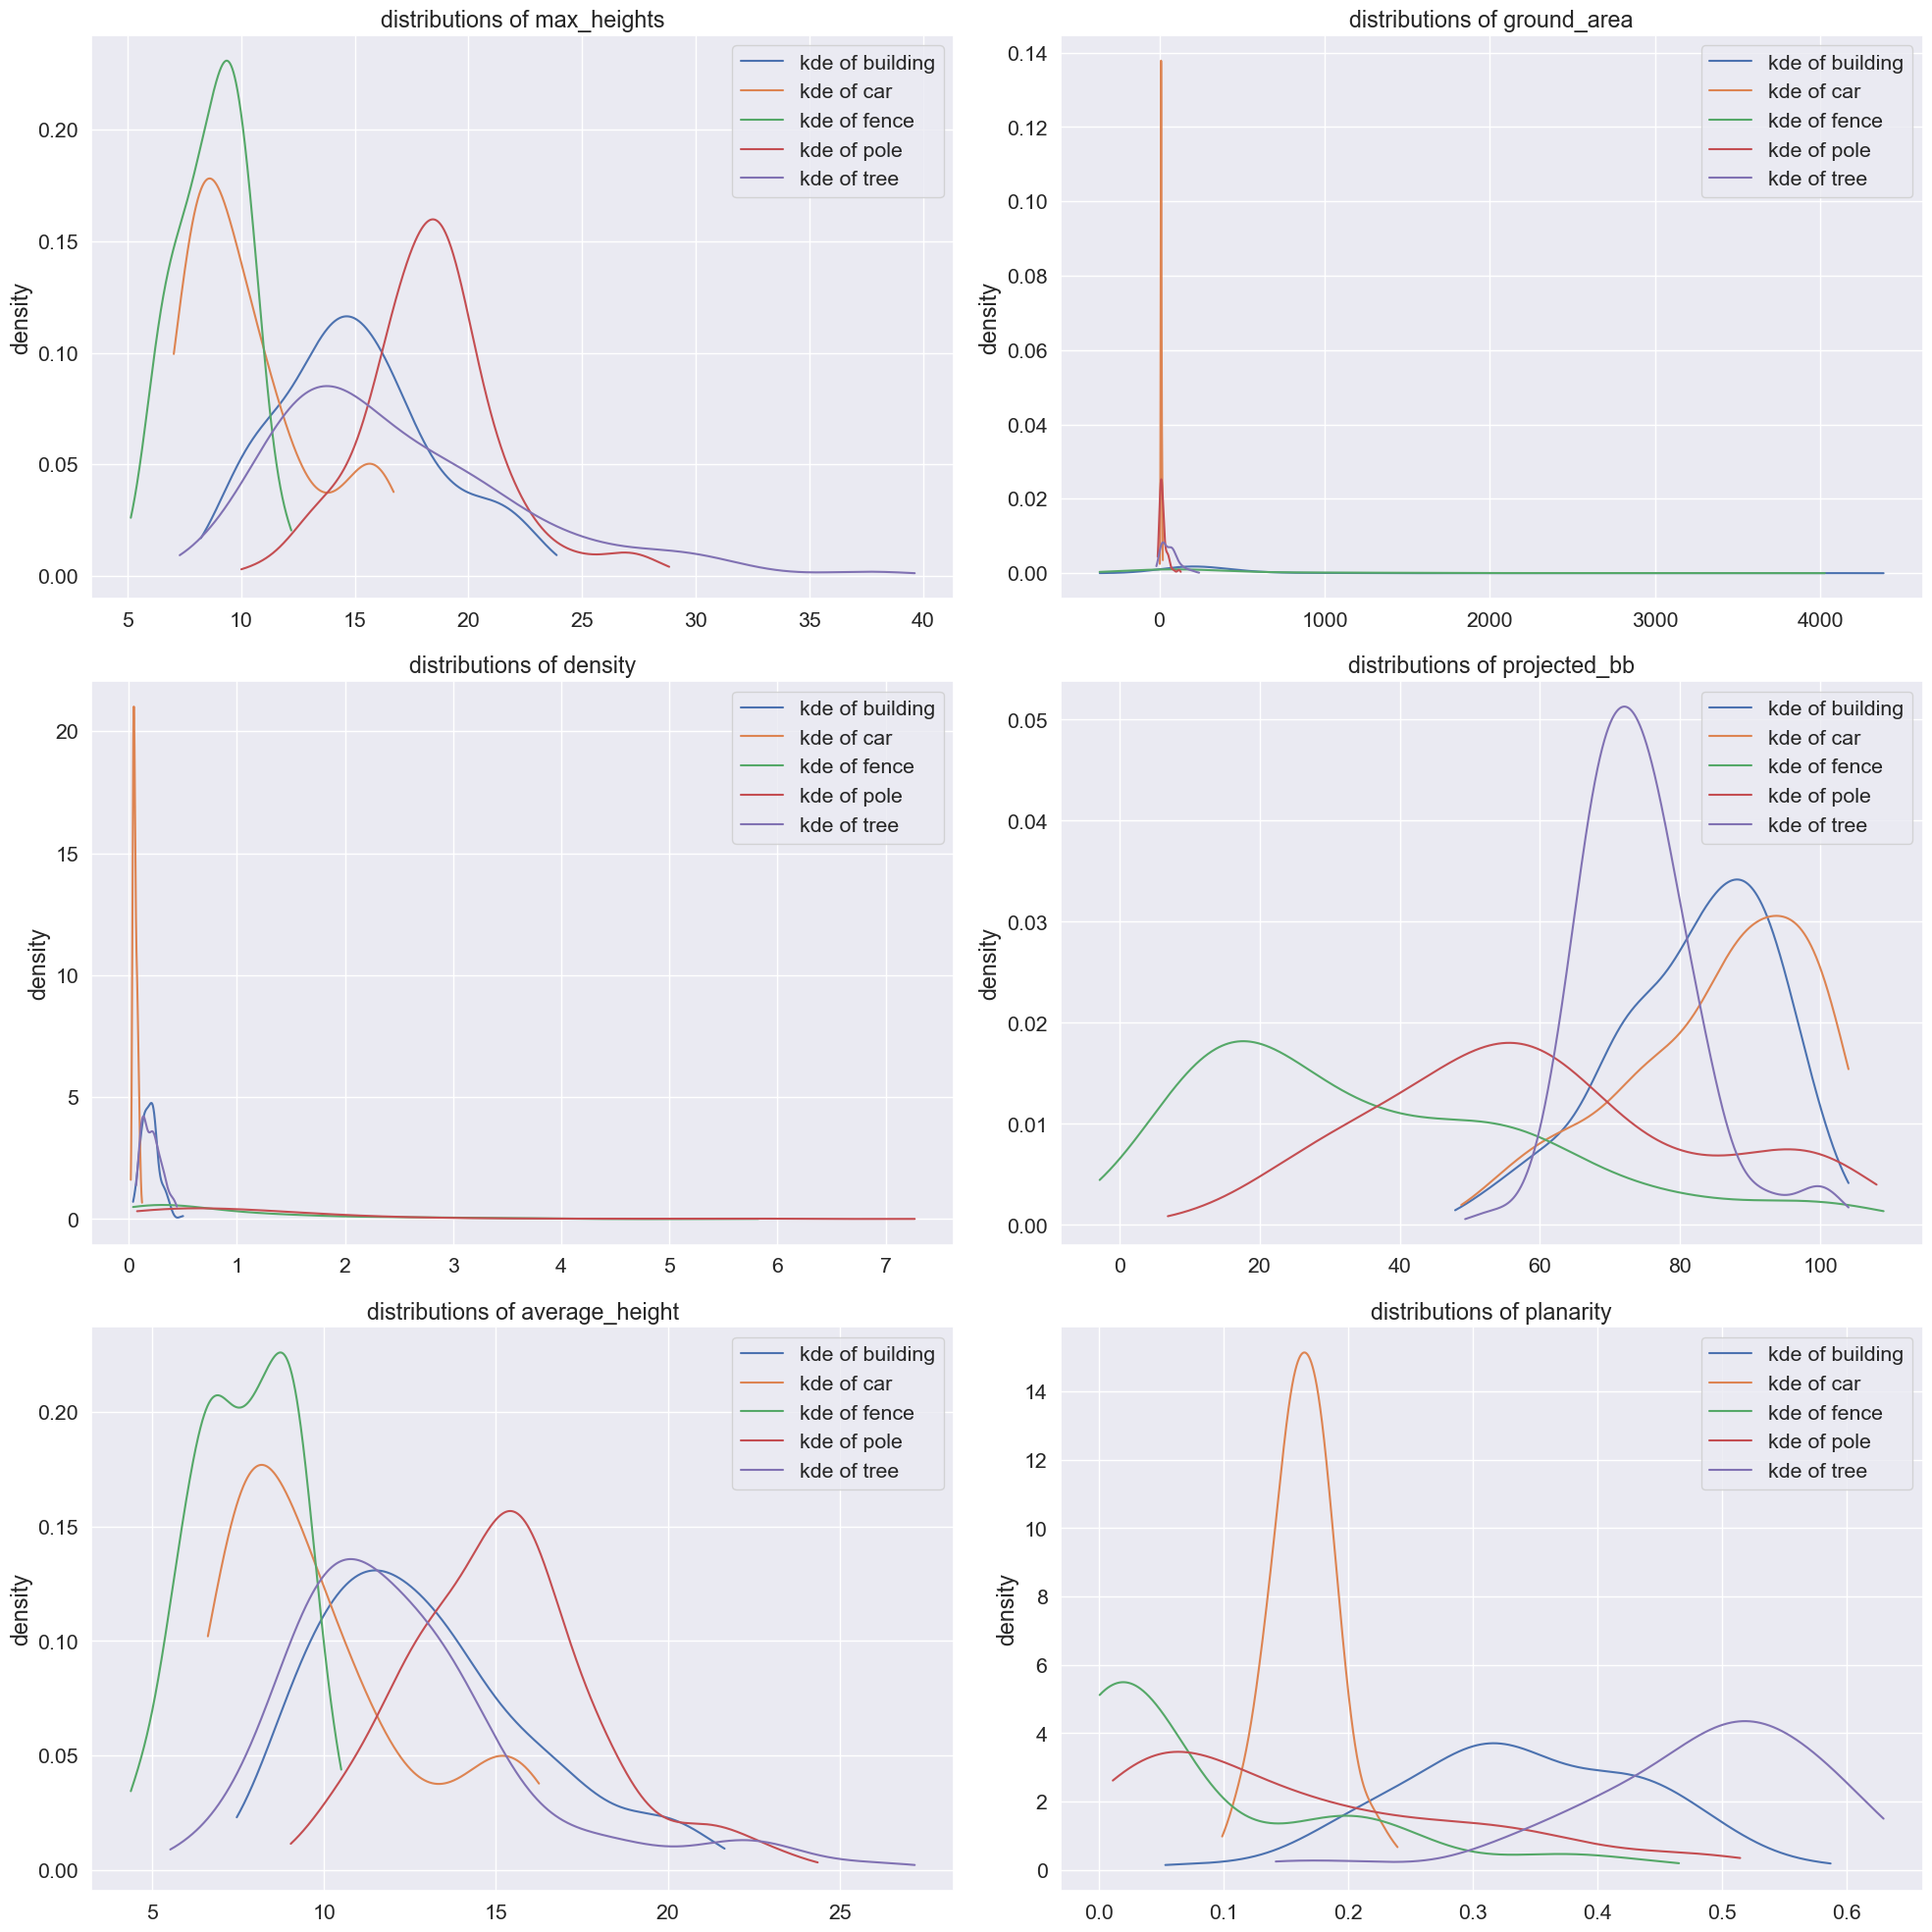

In [142]:
def distributions(dataframe):

    fig, axs = plt.subplots(int((dataframe.shape[1]-1)/2), 2, figsize=(20, 20))

    for i, ax in enumerate(axs.flatten()):
        data_name = feature_names[i]
        for class_name in class_names:
            data = features[features['label'] == class_name][data_name]
            
            mean, std_dev = np.mean(data), np.std(data)
            range = max(data) - min(data)
            
            x = np.linspace(min(data)-int(range/10), max(data)+int(range/10), 1000)
            pdf = norm.pdf(x, loc=mean, scale=std_dev)
            kde = gaussian_kde(data)
            # ax.plot(x, pdf, label=f'pdf of {class_name}')
            ax.plot(x, kde(x), label=f'kde of {class_name}')
            # ax.hist(data, bins=20, density=True, label=f'histogram of {class_name}')
        ax.set_title(f'distributions of {data_name}')
        ax.legend()
        ax.set_ylabel(f'density')
        
    plt.tight_layout()
    plt.show()

distributions(features)


In [ ]:
def pointclouds(data_frame, data_1, data_2):
    

In [23]:
# function to split the train:test data
# features used in X_train and X_test
# corresponding labels used in y_train and y_test
# stratify parameter can be used when classes are imbalanced, here they are balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# scaling the feature set to improve the performance of the machine learning model
# different features have various scale, range, value so that creates an issue
scale_feature = StandardScaler()
X_train = scale_feature.fit_transform(X_train)
X_test = scale_feature.transform(X_test)

# create the SVM classifier
classify_func = svm.SVC(C=3, kernel='rbf', gamma='scale', random_state=42)

# train the classifier using the training data
classify_func.fit(X_train, y_train)

SVC(C=3, random_state=42)

Feature Importance of SVM:
density: 0.079
projected_bb: 0.095
ground_area: 0.172
average_height: 0.176
max_heights: 0.274
planarity: 0.334



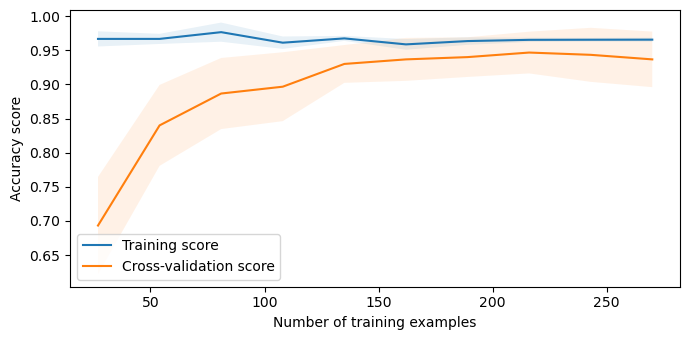

In [24]:
# feature importance for svm
feature_importance_svm = permutation_importance(classify_func, X_test, y_test)
feature_names = np.array(feature_names)
sorted_idx = feature_importance_svm.importances_mean.argsort()
feat_svm = feature_names[sorted_idx]
score_svm = feature_importance_svm.importances_mean[sorted_idx]

# Print feature names and their importance's in a sorted list
print("Feature Importance of SVM:")
for i in range(len(feat_svm)):
    print(f"{feat_svm[i]}: {round(score_svm[i],3)}")
print()

# learning curve
train_sizes, train_scores, test_scores = learning_curve(
   classify_func, X_train, y_train, cv=10, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

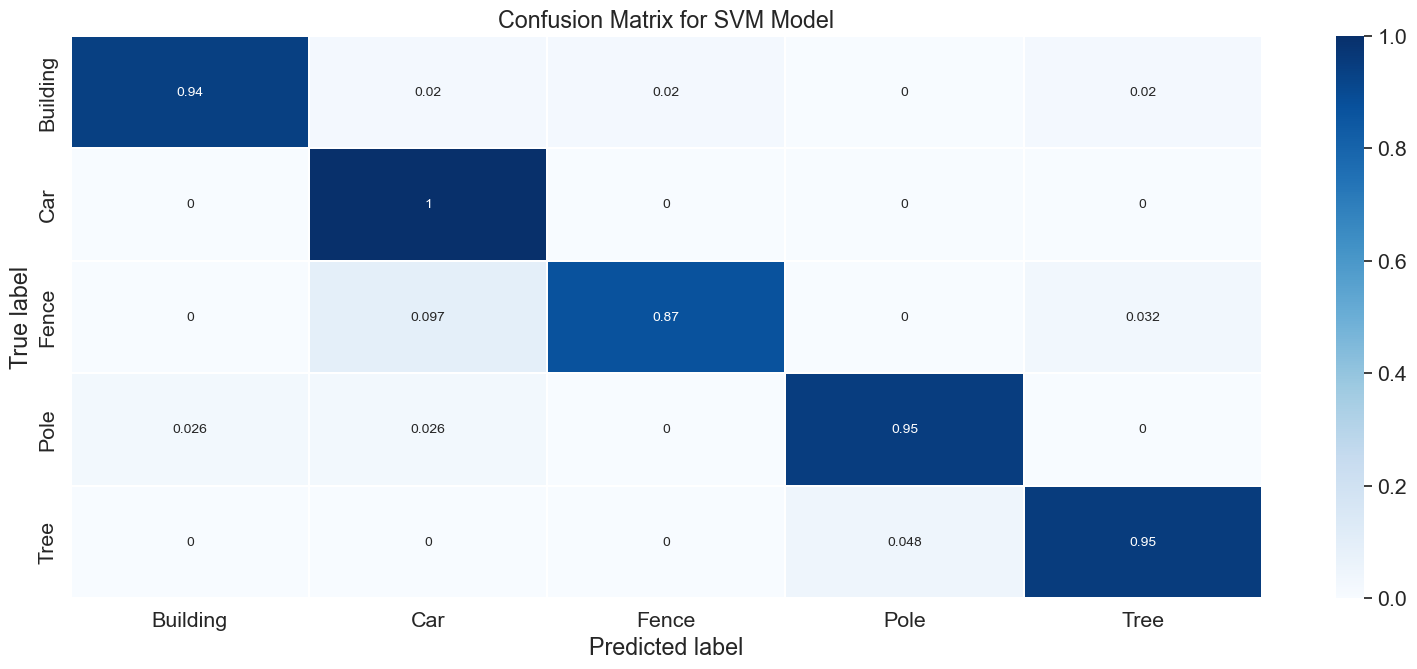

Accuracy:  0.945
svm report: 
              precision    recall  f1-score   support

    building      0.979     0.940     0.959        50
         car      0.884     1.000     0.938        38
       fence      0.964     0.871     0.915        31
        pole      0.949     0.949     0.949        39
        tree      0.952     0.952     0.952        42

    accuracy                          0.945       200
   macro avg      0.946     0.942     0.943       200
weighted avg      0.947     0.945     0.945       200



In [26]:
# y_hat holds the predicted values of trained svm model
y_hat = classify_func.predict(X_test)


# create confusion matrix with y_hat and y_test
# confusion matrix compares values from y_hat with y_test using sklearn.metrics
# confusion matrix shows True positive(TP), False positive(FP), True negative(TN), False negative(FN)
# https://www.v7labs.com/blog/confusion-matrix-guide
conf_matrix = confusion_matrix(y_pred=y_hat, y_true=y_test)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot through heatmap
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Blues, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for SVM Model')
plt.show()

# evaluate the accuracy of the classifier
# accuracy = (TP + TN) / (TP + TN + FP + FN)  [predicted/ total]
accuracy = classify_func.score(X_test, y_test)
print('Accuracy: ', accuracy)
print('svm report: ')
print(classification_report(y_test, y_hat, digits=3, zero_division=1))

Feature importance: 0, Score: 0.14530
Feature importance: 1, Score: 0.18806
Feature importance: 2, Score: 0.20890
Feature importance: 3, Score: 0.14265
Feature importance: 4, Score: 0.10083
Feature importance: 5, Score: 0.21426


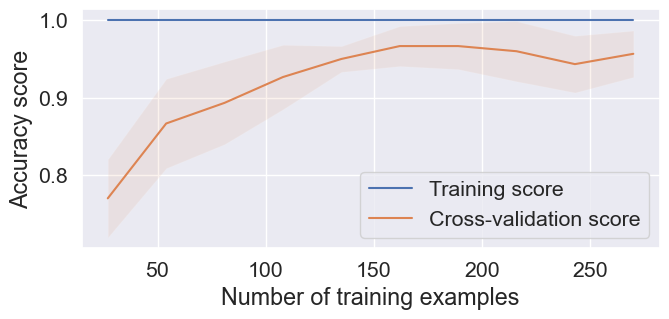

In [27]:
# train a random forest classifier
rfc = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=100, random_state=42, oob_score=True, max_features='sqrt')

# train the classifier using the training data
rfc.fit(X_train, y_train)

# feature importance for rf
importance = rfc.feature_importances_
for i, v in enumerate(importance):
    print('Feature importance: %0d, Score: %.5f' % (i, v))

# calculate the predictions on the test set
y_hat_rf = rfc.predict(X_test)

# learning curve
train_sizes, train_scores, test_scores = learning_curve(
   rfc, X_train, y_train, cv=10, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

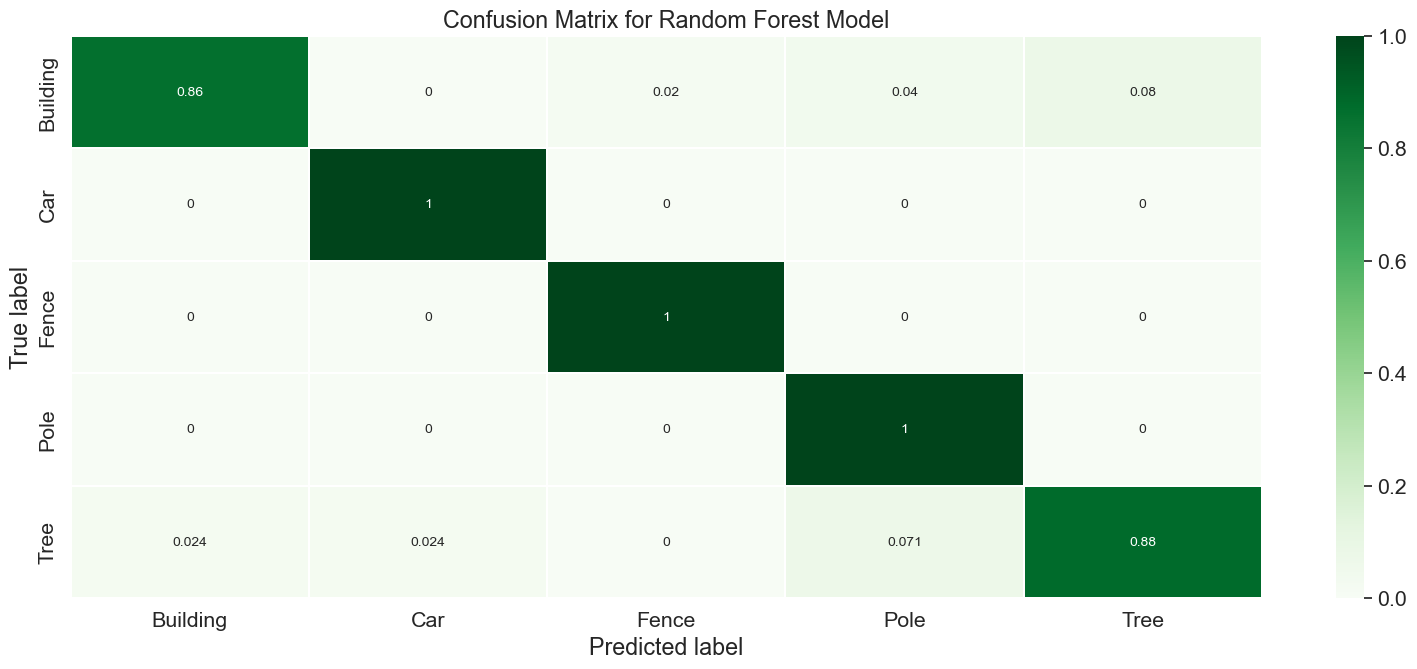

Accuracy:  0.94
F1 score:  0.9392774820383125
rf report: 
              precision    recall  f1-score   support

    building      0.977     0.860     0.915        50
         car      0.974     1.000     0.987        38
       fence      0.969     1.000     0.984        31
        pole      0.886     1.000     0.940        39
        tree      0.902     0.881     0.892        42

    accuracy                          0.940       200
   macro avg      0.942     0.948     0.943       200
weighted avg      0.942     0.940     0.939       200



In [28]:
# create confusion matrix
conf_matrix = confusion_matrix(y_pred=y_hat_rf, y_true=y_test)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot through heatmap
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Greens, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# calculate the accuracy of the classifier
# can also calculate F1 score if required
# F1 = 2 * (precision * recall) / (precision + recall)
# precision measures how many of the predicted positives are actually positive
# recall measures how many of the actual positives are correctly identified by the model
accuracy = accuracy_score(y_test, y_hat_rf)
f1 = f1_score(y_true=y_test, y_pred=y_hat_rf, average='weighted')
print('Accuracy: ', accuracy)
print('F1 score: ', f1)
print('rf report: ')
print(classification_report(y_test, y_hat_rf, digits=3, zero_division=1))
